# DLLP 0 - Quick review of basic Machine Learning concepts
This notebook is meant to be a short summary of Machine Learning (ML) concepts that we are going to refer to extensively in the following. Furthermore, it will introduce: an algorithm that we are going to use as a comparison for performances on tabular data, XGBoost (eXtreme Gradient Boosting); the OpenML library, that provides access to a large repository of different data sets; and a few utils from scikit-learn to visualize the results of a regression or a classification.

## Regression
Regression is a classic task of supervised ML, where the objective is to create a model able to predict the floating-point value of a target variable, starting from the values of other variables (called features). Let's first load a data set for regression from the OpenML repository (https://openml.org/) and take a look at the data.

In [ ]:
# install the openml library; openml is a large collection of openly accessible datasets
!pip install openml

In [1]:
# load the dataset
import openml
dataset = openml.datasets.get_dataset(189)

# print some output
print(dataset)

OpenML Dataset
Name..........: kin8nm
Version.......: 1
Format........: ARFF
Upload Date...: 2014-04-23 13:16:04
Licence.......: Public
Download URL..: https://api.openml.org/data/v1/download/3626/kin8nm.arff
OpenML URL....: https://www.openml.org/d/189
# of features.: 9
# of instances: 8192


C:\Users\Alberto\anaconda3\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


The regression task on this data set is to estimate the kinematics of a robot arm, starting from other measurements. Now, let's perform some pre-processing steps on the data.

First, we will obtain the data as a Pandas dataframe, which is easier to manipulate. Then, we will check if categorical features are present (features assuming discrete values such as 'high'/'medium'/'low' or 'red'/'blue'/'green'), and convert the categorical values to integers. Finally, we will extract the data from the Pandas dataframe as numpy arrays, one with all the features 'X', and the other containing just our target variable that we are interested in predicting, 'y'.

In [2]:
# get the data from the dataset as a dataframe, an object that makes it easy to manipulate
# datasets; for example, dataframes allow you to index columns by name, remove non-valid values
# transform categorical features into numerical features, etc.
df, *_ = dataset.get_data()
print(df)

# as you noticed, some of the columns contain strings instead of numbers; we call these
# "categorical" columns or features. We need to change that, as most ML algorithms
# only process numbers. Don't worry too much about this part, it's just replacing strings
# with numbers
categorical_columns = df.select_dtypes(include=['category', 'object', 'string']).columns
print("I found a total of %d categorical features." % len(categorical_columns))
for c in categorical_columns :
  df[c].replace({category : index for index, category in enumerate(df[c].astype('category').cat.categories)}, inplace=True)

# also, remove all rows that contain invalid numerical values (for example, missing values)
df.dropna(inplace=True)

# name of the target column
target_feature = dataset.default_target_attribute
other_features = [c for c in df.columns if c != target_feature]

# get just the data without the column headers, as numerical matrices
X = df[other_features].values
y = df[target_feature].values

print("X=", X)
print("y=", y)

        theta1    theta2    theta3    theta4    theta5    theta6    theta7  \
0    -0.015119  0.360741  0.469398  1.309675  0.988024 -0.025493  0.664071   
1     0.360478 -0.301395  0.629183 -1.440146 -0.741637 -1.196749 -1.038444   
2     1.563238 -1.294753  0.078987  1.432937  1.149136 -1.292140  1.562988   
3     0.199485  0.901157 -1.356304 -0.080525 -0.976628  0.829894 -0.855649   
4     0.659737  0.120552 -0.008756  0.648839  0.626832 -0.646539  1.318074   
...        ...       ...       ...       ...       ...       ...       ...   
8187  1.459523 -0.201551 -0.610721  1.424181  0.269273  1.172781 -0.509818   
8188  0.654980 -0.823516 -0.809246  0.408441 -1.368838  0.582222 -1.394697   
8189  0.103862  1.024329 -1.047221  0.280905 -0.181155 -0.651934 -1.241842   
8190 -1.109311 -0.027690 -1.448736 -0.648566 -0.462142  0.814971  1.100615   
8191  1.155010 -0.429331 -1.567260  0.883077 -1.203777 -0.126506  0.331042   

        theta8         y  
0     0.062763  0.536524  
1    -0.7

In this particular case there are no categorical features, but checking for their presence is always a good practice. Another common pre-processing step is to check for missing data (e.g. samples with values missing for some of the features), and decide what to do with them. Typical solutions include just discarding the samples with missing values (but this might greatly reduce the amount of data at your disposal) or trying to 'guess' the missing values using [imputation techniques](https://scikit-learn.org/stable/modules/impute.html), another ML technique whose description is out of scope for this class, but for which you can find more information in the link.

Now, we might be tempted to perform a normalization on the values of X and y, but normalizing the data at this point is a (common) **mistake**. We have to wait to split the data between a training and a test set, because a normalization also has parameters (mean and standard deviation of a feature, for example), so it should be *learned on the training set* and just *applied to the test set*. That is, unless you already know in advance the theoretical minimum and maximum possible value of each feature. In this case, we do not know; so we wait.

Let's proceed by splitting the data into a training set and a test set, and applying a normalization that is learned on the training set and applied to the test set.

In [3]:
# train_test_split is a utility function that randomly divides the data into training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) # we use 10% of the data for the test, the rest for the training

print("The training set contains %d samples and %d features; the test set contains %d samples and %d features" %
      (X_train.shape[0], X_train.shape[1], X_test.shape[0], X_test.shape[1]))

# StandardScaler is an object that is able to learn and apply a normalization
# that reduces the values of a feature to zero mean and unitary variance
# so that most of the data values of a feature will fall into the interval (-1,1)
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler() # we need a separate instance of the StandardScaler object for X and y
scaler_y = StandardScaler()

scaler_X.fit(X_train)
scaler_y.fit(y_train.reshape(-1,1))

X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# don't worry too much about all this reshaping going on here, these function like
# to have their inputs in a particular way, but the functions later like another
# type of input, so we are forced to reshape and reshape again
y_train_scaled = scaler_y.transform(y_train.reshape(-1,1)).reshape(-1,)
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).reshape(-1,)

print("y_test=", y_test)
print("y_test_scaled=", y_test_scaled)

The training set contains 7372 samples and 8 features; the test set contains 820 samples and 8 features
y_test= [0.98661326 1.1281729  0.70635852 0.73741319 0.45144399 1.0338823
 0.70030463 0.54849691 0.89943106 1.1755284  0.6119126  0.59742335
 0.46657722 0.29732884 0.77442178 1.1239884  0.84704876 0.88890015
 0.9528564  0.85198333 1.0303809  0.48517692 0.72189488 0.9305579
 0.50018691 0.63792046 1.0301195  0.72962804 0.52529249 0.81483338
 0.92686121 1.0729443  0.97003667 0.54504647 0.68667491 0.26348877
 0.77423808 0.52783507 1.0361829  0.86360925 0.20930304 0.84831686
 0.30517721 0.52064322 0.75607097 0.82588655 0.93654357 0.84771354
 0.82188204 0.63537678 1.1000334  1.0893421  0.36382394 0.53413593
 0.39740249 0.46844292 0.24448121 0.63754335 0.61397343 0.75812719
 0.41239885 0.17542429 0.89676779 1.2935322  0.65979765 0.84235343
 0.41946612 1.204725   0.28132569 1.2115252  1.0346758  0.2688562
 0.68320565 0.92377632 0.6922065  0.61705834 0.81457881 1.0877144
 0.3458826  0.8915204

Now, we are ready to run our first ML regression algorithm! Let's start with a classic linear regression.

In [4]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()

# the model is trained by showing it the 'correct answer' for each sample
regressor.fit(X_train_scaled, y_train_scaled)

# once the model is trained, we can obtain its predictions for both the training set
# and the test set
y_train_pred = regressor.predict(X_train_scaled)
y_test_pred = regressor.predict(X_test_scaled)

After that we have to check if the performance of the algorithm was good. There are several ways of doing that: First we can evaluate a few metrics that try to summarize the whole performance on the sets.

The Mean Squared Error (MSE) can be harder to interpret, as its value depends on the original values of the target variable:

\begin{equation}
MSE = \frac{ \sum\limits_{i=0}^N{(y_i - \hat{y}_i)^2} }{ N }
\end{equation}

where $y_i$ is the measured value of the target variable for sample $i$, $\hat{y}_i$ is the prediction of the trained model for sample $i$, and $N$ is the number of samples. To make it more interpretable, we could either normalize the target variable (but this brings more issues, as we will see later), or use $R2$ (the coefficient of correlation):

\begin{equation}
R2 = 1 - \frac{ \sum\limits_{i=0}^N{(y_i - \hat{y}_i)^2} }{ \sum\limits_{i=0}^N{(y_i - \bar{y})^2} }
\end{equation}

where $\bar{y}$ is the mean value of $y$ over the available $N$ samples. In general, $R2$ is easier to interpret as values close to $1.0$ show that the model performs well, and values close to $0.0$ (or negative) show that the model is garbage.

In [5]:
from sklearn.metrics import mean_squared_error, r2_score

mse_train = mean_squared_error(y_train_scaled, y_train_pred)
mse_test = mean_squared_error(y_test_scaled, y_test_pred)
r2_train = r2_score(y_train_scaled, y_train_pred)
r2_test = r2_score(y_test_scaled, y_test_pred)

print("MSE on training data: %.4f; MSE on test data: %.4f" % (mse_train, mse_test))
print("R2 on training data: %.4f; R2 on test data: %.4f" % (r2_train, r2_test))

MSE on training data: 0.5877; MSE on test data: 0.5558
R2 on training data: 0.4123; R2 on test data: 0.4286


We can also visualize the results, with a classic "measured vs predicted" plot. A perfect predicton would have all points aligned on the middle line predicted=measured.

Text(0.5, 1.0, 'Predicted vs measured (test), R2=0.4286')

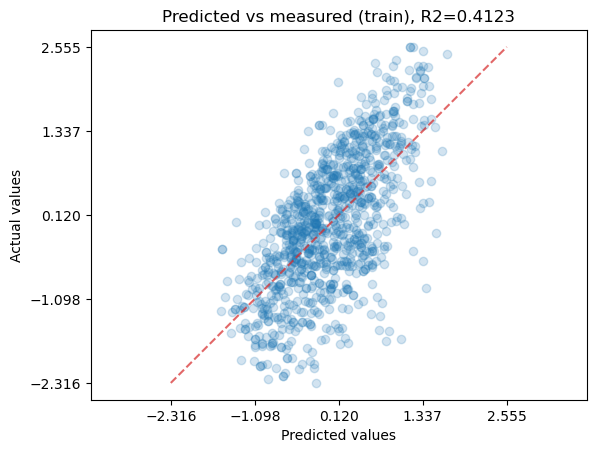

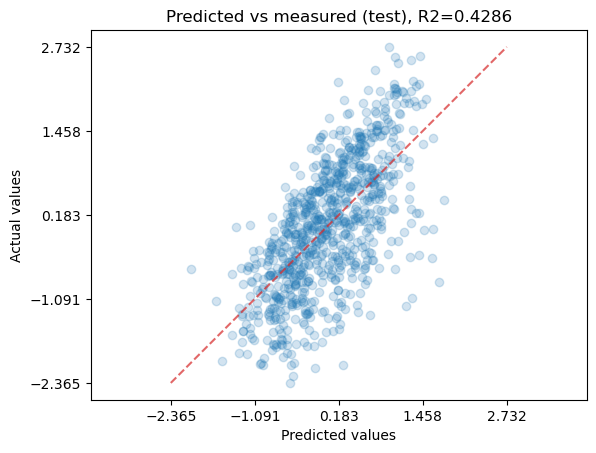

In [6]:
from sklearn.metrics import PredictionErrorDisplay
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
display = PredictionErrorDisplay.from_predictions(
        y_true=y_train_scaled,
        y_pred=y_train_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
ax.set_title("Predicted vs measured (train), R2=%.4f" % r2_train)

fig = plt.figure()
ax = fig.add_subplot(111)
display = PredictionErrorDisplay.from_predictions(
        y_true=y_test_scaled,
        y_pred=y_test_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
ax.set_title("Predicted vs measured (test), R2=%.4f" % r2_test)

The results don't look that great, but on the other hand the Linear Regression shows almost no sign of overfitting: Its performance on the training set is almost identical to its performance on the test set.

Now, let's try a couple of more efficient regressors. Complete the cell below with the code to train, test, and plot the results for the Random Forest and XGBoost regressors. What can you notice? Are they more performing in general? What about the overfitting?

Text(0.5, 1.0, 'RF, predicted vs measured (test), R2=0.7186')

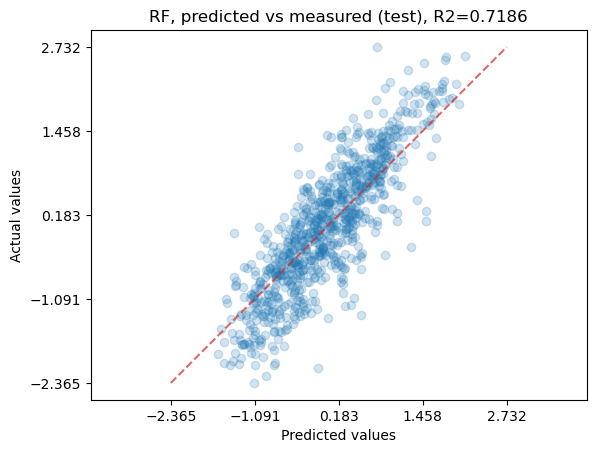

In [9]:
from sklearn.ensemble import RandomForestRegressor
# to obtain the same performance every time, fix random_state to a constant
# e.g., random_state=42, when you call the builder
regressor_rf = RandomForestRegressor()

regressor_rf.fit(X_train_scaled, y_train_scaled)
y_train_pred_rf = regressor_rf.predict(X_train_scaled)
y_test_pred_rf = regressor_rf.predict(X_test_scaled)

r2_test_rf = r2_score(y_test_scaled, y_test_pred_rf)

fig = plt.figure()
ax = fig.add_subplot(111)
display = PredictionErrorDisplay.from_predictions(
        y_true=y_test_scaled,
        y_pred=y_test_pred_rf,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
ax.set_title("RF, predicted vs measured (test), R2=%.4f" % r2_test_rf)


Text(0.5, 1.0, 'XGB, predicted vs measured (test), R2=0.7633')

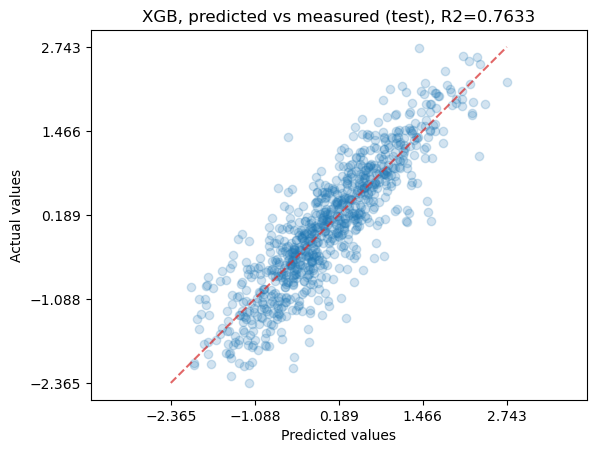

In [10]:
from xgboost import XGBRegressor
# to obtain the same performance every time, fix random_state to a constant
# e.g., random_state=42, when you call the builder
regressor_xgb = XGBRegressor()

regressor_xgb.fit(X_train_scaled, y_train_scaled)
y_train_pred_xgb = regressor_xgb.predict(X_train_scaled)
y_test_pred_xgb = regressor_xgb.predict(X_test_scaled)

r2_test_xgb = r2_score(y_test_scaled, y_test_pred_xgb)

fig = plt.figure()
ax = fig.add_subplot(111)
display = PredictionErrorDisplay.from_predictions(
        y_true=y_test_scaled,
        y_pred=y_test_pred_xgb,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
ax.set_title("XGB, predicted vs measured (test), R2=%.4f" % r2_test_xgb)

Now, try running the cell with Random Forest again. Do you get exactly the same value of $R2$? Why is that?

Find a way to obtain the <ins>exact same result</ins> every time you run Random Forest. You can find the documentation of Random Forest here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

## Classification

Classification is another extremely common task in supervised ML. Together, classification and regression problems comprise the majority of supervised ML tasks. Differently from regression, where the objective is to predict the continuous value of a target feature, classification assigns a sample to a class (a discrete value); the classification's objective is thus to predict the value of a target feature, which is this time a discrete label (for example, 'Class A'/'Class B', 'Healthy'/'Unhealthy', 'High risk'/'Medium risk'/'Low risk').

Again, let's examine a classification task taken from OpenML, where the objective is to predict whether the level of ozone in an area will be harmless for human health (Class 0) or potentially dangerous (Class 1), starting from the measurements of other features.

In [11]:
import openml

dataset = openml.datasets.get_dataset(1487)
print(dataset)

C:\Users\Alberto\anaconda3\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


OpenML Dataset
Name..........: ozone-level-8hr
Version.......: 1
Format........: ARFF
Upload Date...: 2015-05-25 19:22:29
Licence.......: Public
Download URL..: https://api.openml.org/data/v1/download/1592279/ozone-level-8hr.arff
OpenML URL....: https://www.openml.org/d/1487
# of features.: 73
# of instances: 2534


Let's obtain the data as a Pandas dataframe, and then perform some pre-processing.

In [12]:
df, *_ = dataset.get_data()
print(df)

# as you noticed, some of the columns contain strings instead of numbers; we call these
# "categorical" columns or features. We need to change that, as most ML algorithms
# only process numbers. Don't worry too much about this part, it's just replacing strings
# with numbers
categorical_columns = df.select_dtypes(include=['category', 'object', 'string']).columns
print("I found a total of %d categorical features." % len(categorical_columns))
if len(categorical_columns) > 0 :
  print(categorical_columns)
for c in categorical_columns :
  df[c].replace({category : index for index, category in enumerate(df[c].astype('category').cat.categories)}, inplace=True)

# also, remove all rows that contain invalid numerical values (for example, missing values)
df.dropna(inplace=True)

# name of the target column
target_feature = dataset.default_target_attribute
other_features = [c for c in df.columns if c != target_feature]

# get just the data without the column headers, as numerical matrices
X = df[other_features].values
y = df[target_feature].cat.codes.values # this transforms 'categorical' integers to values, don't worry too much about it

print("X=", X)
print("y=", y)

       V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  ...       V64  \
0     0.8  1.8  2.4  2.1  2.0  2.1  1.5  1.7  1.9  2.3  ...  0.150000   
1     2.8  3.2  3.3  2.7  3.3  3.2  2.9  2.8  3.1  3.4  ...  0.480000   
2     2.9  2.8  2.6  2.1  2.2  2.5  2.5  2.7  2.2  2.5  ...  0.600000   
3     4.7  3.8  3.7  3.8  2.9  3.1  2.8  2.5  2.4  3.1  ...  0.490000   
4     2.6  2.1  1.6  1.4  0.9  1.5  1.2  1.4  1.3  1.4  ...  0.304716   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
2529  0.3  0.4  0.5  0.5  0.2  0.3  0.4  0.4  1.3  2.2  ...  0.070000   
2530  1.0  1.4  1.1  1.7  1.5  1.7  1.8  1.5  2.1  2.4  ...  0.040000   
2531  0.8  0.8  1.2  0.9  0.4  0.6  0.8  1.1  1.5  1.5  ...  0.060000   
2532  1.3  0.9  1.5  1.2  1.6  1.8  1.1  1.0  1.9  2.0  ...  0.250000   
2533  1.5  1.3  1.8  1.4  1.2  1.7  1.6  1.4  1.6  3.0  ...  0.540000   

            V65        V66          V67        V68        V69           V70  \
0     10.670000  -1.560000  5795.000000 -12.

Our data is ready! We can now proceed to perform a train/test split, and train a first linear classifier, Logistic Regression.

In [13]:
# train_test_split is a utility function that randomly divides the data into training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) # we use 10% of the data for the test, the rest for the training

print("The training set contains %d samples and %d features; the test set contains %d samples and %d features" %
      (X_train.shape[0], X_train.shape[1], X_test.shape[0], X_test.shape[1]))

# StandardScaler is an object that is able to learn and apply a normalization
# that reduces the values of a feature to zero mean and unitary variance
# so that most of the data values of a feature will fall into the interval (-1,1)
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler() # this time, we don't need to scale 'y', that contains integer values

scaler_X.fit(X_train)

# we are overwriting X_train and X_test here, which might not be best practice;
# but after this, we no longer need the unscaled X_train and X_test, so this should be ok
X_train = scaler_X.transform(X_train)
X_test = scaler_X.transform(X_test)

print("y_train=", y_train)
print("y_test=", y_test)

The training set contains 2280 samples and 72 features; the test set contains 254 samples and 72 features
y_train= [0 0 1 ... 0 0 0]
y_test= [0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0]


In [14]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

classifier.fit(X_train, y_train)

y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

C:\Users\Alberto\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


This time, to check performance, we could just use the accuracy (number of samples correctly classified over total number of samples in the set). Let's see what we got.

In [15]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print("Accuracy on training set: %.4f; accuracy on test set: %.4f" % (accuracy_train, accuracy_test))

Accuracy on training set: 0.9456; accuracy on test set: 0.9488


That looks impressive! However, there might be a little issue. Print out the number of samples for each class in the original dataset.

In [16]:
unique_labels = df["Class"].unique()
counts = []
for label in unique_labels :
  counts.append(df[df["Class"] == label].shape[0])
  print("For class \"%s\", I found a total of %d samples." % (label, counts[-1]))


For class "0", I found a total of 2374 samples.
For class "1", I found a total of 160 samples.


Ouch! It looks like the samples from the two classes are completely unbalanced! This means that by always predicting the majority class, we would get an accuracy higher than $0.93$! Luckily, we can rely upon other metrics to evaluate the performance of our algorithm, for example $F1$:

\begin{equation}
F1 = \frac{TP}{TP + \frac{FP+FN}{2}}
\end{equation}

Where $TP$ are true positives (samples belonging to the 'positive' or first class, correctly assigned to the first class label), $FP$ are the false positives (samples incorrectly assigned to the first class label), $FN$ are the false negatives (samples incorrectly assigned to the second class label). $F1$ is generally intuitive to interpret, as values close to $1.0$ indicate good performance, and values close to $0.0$ indicate poor performance.

Calling class labels 'positive' and 'negative' is just a convention that comes from the history of binary classification, don't worry too much about it. In fact, when the two classes cannot really be called 'positive' or 'negative', $F1$ has an option of returning the average between two $F1$ computations, one performed considering the first class as 'positive', the other performed considering the second class as 'positive'.

Let's try $F1$ and see if it agrees with the excellent value we got for accuracy.

In [17]:
from sklearn.metrics import f1_score

f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print("F1 on training: %.4f; F1 on test: %.4f" % (f1_train, f1_test))

# hmmm, maybe we get a better result by using an average?
f1_train_average = f1_score(y_train, y_train_pred, average="macro")
f1_test_average = f1_score(y_test, y_test_pred, average="macro")

print("F1 (averaged) on training: %.4f; F1 (averaged) on test: %.4f" % (f1_train_average, f1_test_average))

F1 on training: 0.4464; F1 on test: 0.3810
F1 (averaged) on training: 0.7089; F1 (averaged) on test: 0.6771


Uops. Looks like our algorithm is not performing that well, after all. Another nice way to visualize classification results is a confusion matrix, a classic plot that indicates what kind of mistakes the algorithm is performing.

Text(0.5, 1.0, 'Confusion matrix on test data')

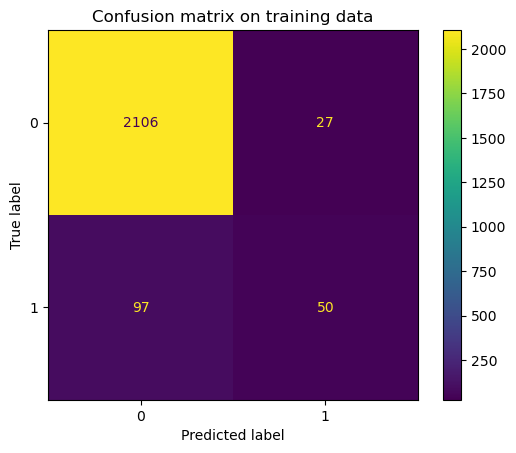

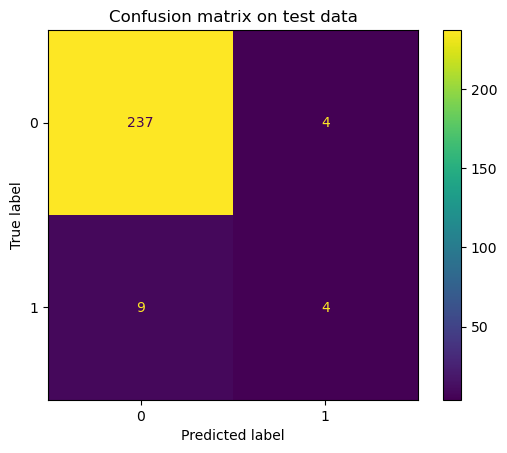

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# create a figure, and display the confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)

cmd = ConfusionMatrixDisplay.from_predictions(
    y_true=y_train,
    y_pred=y_train_pred,
    display_labels=df["Class"].unique(),
    ax=ax,
)

ax.set_title("Confusion matrix on training data")

fig = plt.figure()
ax = fig.add_subplot(111)

cmd = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_test_pred,
    display_labels=df["Class"].unique(),
    ax=ax,
)

ax.set_title("Confusion matrix on test data")

The diagonal of the matrix shows examples that have been correctly classified, but the entire row can give us some food for thought. For example, knowing that a sample belongs to Class 0, what is the probability that it will be correctly classified as Class 0? And knowing that a sample belongs to Class 1, what is the probability that it will be correctly classified?

As expected, the algorithm has the tendency to classify everything as Class 0, the class label for which more samples were available during training. This is an important lesson to remember! An unbalance in the class distribution might lead your ML algorithms to give more importance to the majority class, with unsatisfactory results.

Now, let's try more state-of-the-art algorithms! Complete the code cells below, checking the performance of Random Forest and XGBoost as classifiers using both the $F1$ metric and the confusion matrix.

Text(0.5, 1.0, 'RF, confusion matrix on test data, F1=0.5968')

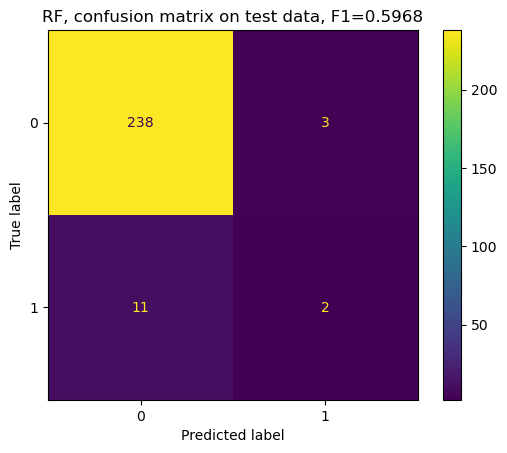

In [22]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier()

classifier_rf.fit(X_train, y_train)
y_test_pred = classifier_rf.predict(X_test)

f1_test_rf = f1_score(y_test, y_test_pred, average="macro")

fig = plt.figure()
ax = fig.add_subplot(111)
cmd = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_test_pred,
    display_labels=df["Class"].unique(),
    ax=ax,
)
ax.set_title("RF, confusion matrix on test data, F1=%.4f" % f1_test_rf)

Text(0.5, 1.0, 'XGB, confusion matrix on test data, F1=0.6584')

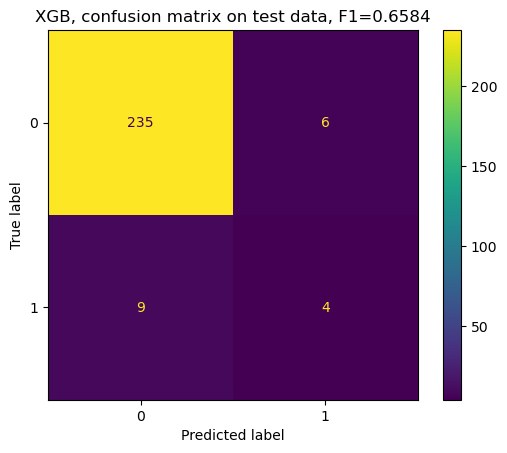

In [23]:
from xgboost import XGBClassifier
classifier_xgb = XGBClassifier()

classifier_xgb.fit(X_train, y_train)
y_test_pred = classifier_xgb.predict(X_test)

f1_test_rf = f1_score(y_test, y_test_pred, average="macro")

fig = plt.figure()
ax = fig.add_subplot(111)
cmd = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_test_pred,
    display_labels=df["Class"].unique(),
    ax=ax,
)
ax.set_title("XGB, confusion matrix on test data, F1=%.4f" % f1_test_rf)

How did it go? Interestingly, dealing with unbalanced classes is a major issue in ML, and even the best algorithms are affected by this problem. One solution, as all ML includes optimization, is to change the objective function to optimize, using weights that will give more importance to correctly classifying samples from the minority class.

Complete the code cells below, where Random Forest and XGBoost have been instantiated with the option to take into account relative class numerosity in their optimization. This should provide a more balanced classification: Check it by using $F1$ and plotting the confusion matrix.

Text(0.5, 1.0, 'RF, confusion matrix on test data, F1=0.5535')

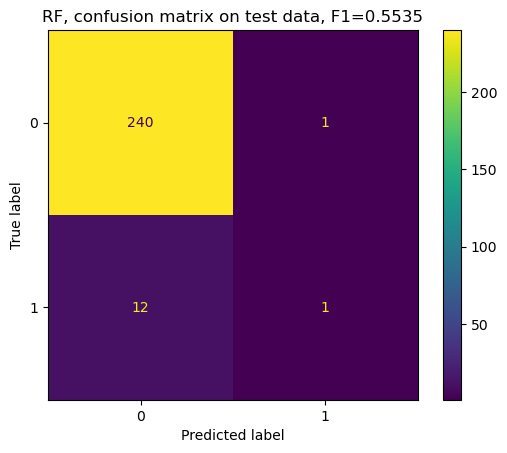

In [24]:
classifier_rf = RandomForestClassifier(class_weight="balanced")

classifier_rf.fit(X_train, y_train)
y_test_pred = classifier_rf.predict(X_test)

f1_test_rf = f1_score(y_test, y_test_pred, average="macro")

fig = plt.figure()
ax = fig.add_subplot(111)
cmd = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_test_pred,
    display_labels=df["Class"].unique(),
    ax=ax,
)
ax.set_title("RF, confusion matrix on test data, F1=%.4f" % f1_test_rf)

Text(0.5, 1.0, 'XGB, confusion matrix on test data, F1=0.7066')

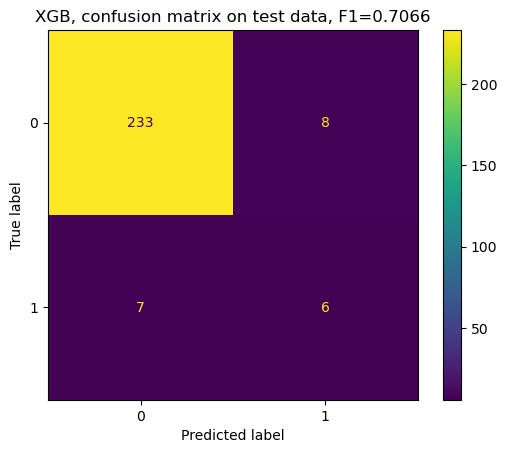

In [25]:
# 'counts' here was initialized above, with the number of samples from each class label
classifier_xgb = XGBClassifier(scale_pos_weight=counts[0]/counts[1], verbosity=0)

classifier_xgb.fit(X_train, y_train)
y_test_pred = classifier_xgb.predict(X_test)

f1_test_rf = f1_score(y_test, y_test_pred, average="macro")

fig = plt.figure()
ax = fig.add_subplot(111)
cmd = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_test_pred,
    display_labels=df["Class"].unique(),
    ax=ax,
)
ax.set_title("XGB, confusion matrix on test data, F1=%.4f" % f1_test_rf)

Was this a bit better? In general, an unbalanced data set is a hard problem for ML classification algorithms. Other possible approaches include data augmentation (that we are going to explore later in the class), [oversampling and undersampling](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis). In practical cases, however, all these techniques typically perform poorly: If you can, strive to have a balanced data set.

## General remarks on testing Machine Learning algorithms

In most practical cases, performing a single training/test split is not enough to properly assess the efficiency of an algorithm (for classification or regression). The best practice is to perform a $k$-fold cross-validation, which just means that the data is going to be split into $k$ groups called _folds_, $F=\{f_1, f_2, ..., f_k\}$. For $k$ iterations, $i=\{1, 2, ..., k\}$, the algorithm will be trained on the set of folds $F_i = \{\forall f_j \in F, j \ne i\}$ and tested on the remaining one $f_i$. This provides an average and a standard deviation of the performance metric on test, which is more reliable than just a single value: You might just get lucky (or unlucky) with the random split. Practitioners very often use $k=5$ or $k=10$, with stratified folds for classification (in other words, each fold preserves approximatively the same proportion of samples of each class that was present in the original dataset).

While it's important to keep in mind that the $k$-fold cross-validation is the best practice to estimate the performance of a ML algorithm on a data set, in the following we are basically never going to use it :-D , as training deep neural networks takes a lot of time (considerably more than Random Forest or XGBoost). We will just use one train/test split.

## Numbers in a computer
A last few words on internal representation of numbers. ML algorithms manipulate floating point values, but it is useful and important to remember that all the values are stored and generated by other algorithms, and everything is hosted on a computer. Numbers in a computer do not behave exactly like we expect them to. See the example below. Once the difference in magnitude between two variables becomes too large or too small, this leads to numerical errors (usually, rounding to the closest representable number). All credit for the following example goes to [Prof. Ken Chiu, Binghamton University](https://twitter.com/kjw_chiu/status/1772017874409869762), and in the link you will also find other examples.

In [26]:
# the two following expressions should be equivalent
x1 = 0.005 + 1e12 - 0.003 - 1e12
x2 = 0.005 + 1e12 - 1e12 - 0.003 # the only thing that changes is the order of elements

print(100*(x1 - 0.001))
print(100*(x2 - 0.001))

0.0953125
0.10048828124999999


As we will see, this can create issues even for neural networks, although most libraries (including pytorch) have some built-in methods to avoid such problems.

It is always useful to remember that, internally in a computer, numbers are represented as sequences of bits. This also imposes constraints on what kind of fractions or reals can be represented, with funny outcomes like the one in the example below.

In [27]:
if 0.1 + 0.2 == 0.3 :
  print("Yes, this OBVIOUSLY makes sense")
else :
  print("You are glancing at a dark abyss of forbidden knowledge here, and delving in its depths might damage your sanity")

You are glancing at a dark abyss of forbidden knowledge here, and delving in its depths might damage your sanity


Knowing what is exactly happening here is outside of the scope of this class, but if you are interested you can find more information in this [nice blog post by Prof. Daniel Lemire, Université du Québec](https://lemire.me/blog/2020/10/10/why-is-0-1-0-2-not-equal-to-0-3/).

As for (pseudo-)random number generation, remember to always **set and store the random seed** to ensure repeatability of your experiments.

In [29]:
import random
random.seed() # this initializes the (pseudo-)random number generator with system time, as it happens if no seed is specified
sequence_unseeded = random.sample(range(1, 10), 5)
print("A sequence that should change every time you run this cell:", sequence_unseeded)

random.seed(42)
sequence_seeded = random.sample(range(1, 10), 5)
print("A sequence that is always the same", sequence_seeded)

A sequence that should change every time you run this cell: [2, 3, 1, 8, 5]
A sequence that is always the same [2, 1, 6, 3, 9]
